# Notebook for the Analysis of Audio Data
---
This notebook perfroms a simple audio analysis based around the [Fast Fourier Transformation](https://en.wikipedia.org/wiki/Fast_Fourier_transform) of wave audio files (wav).
For the import and transformation of the wav files different features from the scipy package are used.

Finally a classification of the files is made using the Extra Trees Classifier provided by scikit learn.


In [41]:
import math
from scipy.io import wavfile
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sn
from tqdm import tqdm


plt.rcParams['figure.facecolor'] = 'white'  # enhances visibility in darkmode IDEs
plt.rcParams["figure.figsize"] = (1.96, 1.96)
plt.rcParams['font.size'] = 4.2


# Data Import #
***
Walk over a directory determined by a given path and append the datapaths of all found files to a list.

In [28]:
_DATAPATHS = []
rootdir = './bachelor_project/Data/Study Recordings'

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        path = os.path.join(subdir, file)
        _DATAPATHS.append(path)


In [3]:
def fourier_transform(data):
    """
    Performs a fast fourier transformation for a given array of wav data.

    :param data: Array of frequency values gained from a wav recording.
    :return: The absolute values of the fourier transformed data.
    """
    transformed_data = fft(data)
    return np.abs(transformed_data[:int((len(transformed_data)/2)-1)])


# Generation of a Data Set
---
The following code block uses the previous imported data path to generate a data set for the latter analysis.
For this the following steps are performed:
   * Read sample rate and freqency data from a wave audio file
   * Reshape the frequencies by applying a StandardScaler from scikit learn
   * Perform the Fast Fourier Transformation for both original data and the scaled data

The final data set contains the information gained from the steps described above as well as other key information about each recording.


In [29]:
from sklearn.preprocessing import StandardScaler

sScaler = StandardScaler()
_DATASET = []

for d in _DATAPATHS:

    # Import the wave audio
    slr, wav_data = wavfile.read(d)

    # Apply StandardScaler to the audio data
    wav_data_standardized = sScaler.fit_transform(wav_data.reshape(-1,1))

    # Apply fft to both Standardized and normal audio data
    # Saved data gets cropped by end and beginning noise of the samples
    fft_data_nonStandard = fourier_transform(np.asarray(wav_data))[5:200000]
    fft_data_Standardized = fourier_transform(np.asarray(wav_data_standardized))[5:200000]

    # Append key informations and audio data to the data set
    _DATASET.append({'path': d,
                    'pid': int(os.path.basename(d).split('_')[0].replace('p', '')),
                    'session': int(os.path.basename(d).split('_')[1].replace('s', '')),
                    'hand': os.path.basename(d).split('_')[2].replace('u', ''),
                    'melody_type': os.path.basename(d).split('_')[3].replace('.wav', '')[0:-1],
                    'samplerate': slr,
                    'wav': wav_data,
                    'wav_standardized': wav_data_standardized,
                    'fft_nonStandard': fft_data_nonStandard,
                    'fft_wthStandard': fft_data_Standardized})


# Plot graphics for the audio data
---
The following three code blocks are each used to plot different variations of the audios from the data set.
   1. Plots of the fft data for all entries of the data set
   2. Plots of the wav audio for all entries of the data set
   3. Plots of all variations of a specific sample grouped by their ID

In [34]:
for d in tqdm(_DATASET):

    plt.title(d['path'].split('_u')[-1].replace('.wav', '_fft'))
    plt.plot(d['fft_wthStandard'], label='p1')
    plt.ticklabel_format(useOffset=False, style='plain')
    plt.savefig(d['path'].split('\\')[-1].replace('.wav', '_fftNorm.pdf'))
    plt.clf()


<Figure size 141.12x141.12 with 0 Axes>

In [42]:
for d in tqdm(_DATASET):

    plt.title(d['path'].split('_u')[-1].replace('.wav', ''))

    data = d['wav']
    length = data.shape[0] / d['samplerate']
    time = np.linspace(0, length, data.shape[0])

    plt.plot(time, data)
    plt.savefig(d['path'].split('\\')[-1].replace('.wav', 'raw_plot.pdf'))
    plt.clf()


<Figure size 141.12x141.12 with 0 Axes>

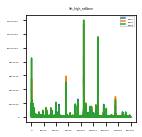

In [64]:
plt.title('left_high_noNorm')
plt.plot(_DATASET[0]['fft_nonStandard'], label='p0h1')
plt.plot(_DATASET[1]['fft_nonStandard'], label='p0h2')
plt.plot(_DATASET[2]['fft_nonStandard'], label='p0h3')
plt.ticklabel_format(useOffset=False, style='plain')
plt.legend()
plt.savefig('p0_allHighs_left_noNorm.pdf')


# Classification of the Audio data
---
Runs a classifier over all entries of the data set.
For the classifier an ExtraTreesClassifier with a number of 1000 estimators is used.
The audio data is sorted by tho keys (hand and sample type/melody).
Training and validation set are split by the session ID of each entry.

As final step the confusion matrices for each classification report are printed and stored as a pdf file.

high r
Accurancy:  33.3333%
              precision    recall  f1-score   support

           0       0.29      0.67      0.40         3
           1       0.00      0.00      0.00         3
           2       0.50      0.33      0.40         3

    accuracy                           0.33         9
   macro avg       0.26      0.33      0.27         9
weighted avg       0.26      0.33      0.27         9

[[2 0 1]
 [3 0 0]
 [2 0 1]]


c:\users\waltmann\johannes_waltmann_bachelorprojekt\study\analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\waltmann\johannes_waltmann_bachelorprojekt\study\analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\waltmann\johannes_waltmann_bachelorprojekt\study\analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

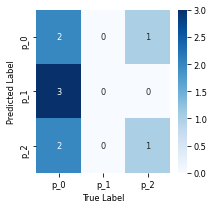

high l
Accurancy:  66.6667%
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       1.00      1.00      1.00         3
           2       0.00      0.00      0.00         3

    accuracy                           0.67         9
   macro avg       0.50      0.67      0.56         9
weighted avg       0.50      0.67      0.56         9

[[3 0 0]
 [0 3 0]
 [3 0 0]]


c:\users\waltmann\johannes_waltmann_bachelorprojekt\study\analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\waltmann\johannes_waltmann_bachelorprojekt\study\analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\waltmann\johannes_waltmann_bachelorprojekt\study\analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

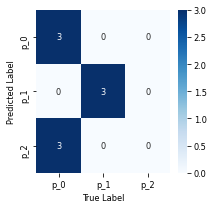

low r
Accurancy:  66.6667%
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       1.00      1.00      1.00         3
           2       0.00      0.00      0.00         3

    accuracy                           0.67         9
   macro avg       0.50      0.67      0.56         9
weighted avg       0.50      0.67      0.56         9

[[3 0 0]
 [0 3 0]
 [3 0 0]]


c:\users\waltmann\johannes_waltmann_bachelorprojekt\study\analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\waltmann\johannes_waltmann_bachelorprojekt\study\analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\waltmann\johannes_waltmann_bachelorprojekt\study\analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

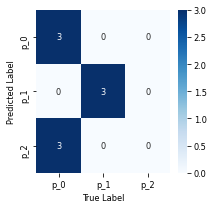

low l
Accurancy:  44.4444%
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.40      0.67      0.50         3
           2       0.00      0.00      0.00         3

    accuracy                           0.44         9
   macro avg       0.47      0.44      0.43         9
weighted avg       0.47      0.44      0.43         9

[[2 0 1]
 [0 2 1]
 [0 3 0]]


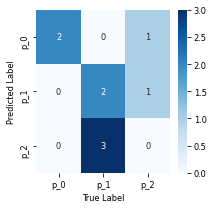

mel r
Accurancy:  55.5556%
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.50      0.67      0.57         3
           2       0.00      0.00      0.00         3

    accuracy                           0.56         9
   macro avg       0.37      0.56      0.44         9
weighted avg       0.37      0.56      0.44         9

[[3 0 0]
 [1 2 0]
 [1 2 0]]


c:\users\waltmann\johannes_waltmann_bachelorprojekt\study\analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\waltmann\johannes_waltmann_bachelorprojekt\study\analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\waltmann\johannes_waltmann_bachelorprojekt\study\analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

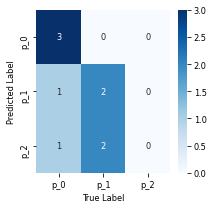

mel l
Accurancy:  33.3333%
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.25      0.33      0.29         3
           2       0.00      0.00      0.00         3

    accuracy                           0.33         9
   macro avg       0.42      0.33      0.36         9
weighted avg       0.42      0.33      0.36         9

[[2 0 1]
 [0 1 2]
 [0 3 0]]


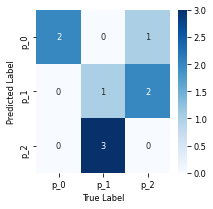

In [26]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


for melody in ['high', 'low', 'mel']:
    for hand in ['r', 'l']:

        x_train = np.array([d['fft_nonStandard'] for d in _DATASET if d['session'] == 0 and d['melody_type'] == melody and d['hand'] == hand]).reshape(9,-1)
        x_val = np.array([d['fft_nonStandard'] for d in _DATASET if d['session'] == 1 and d['melody_type'] == melody and d['hand'] == hand]).reshape(9,-1)

        y_train = np.array([d['pid'] for d in _DATASET if d['session'] == 0 and d['melody_type'] == melody and d['hand'] == hand])
        y_val = np.array([d['pid'] for d in _DATASET if d['session'] == 1 and d['melody_type'] == melody and d['hand'] == hand])


        clf = ExtraTreesClassifier(n_estimators=1000, random_state=0)
        clf.fit(x_train, y_train)

        y_pred = clf.predict(x_val)

        report = classification_report(y_val, y_pred)
        cm = confusion_matrix(y_val, y_pred)
        
        print(melody, hand)
        accuracy = accuracy_score(y_train, y_pred, normalize=True)*100
        print(f'Accurancy: {accuracy: .4f}%')
        print(report)
        print(cm)
        labels = ['p_0', 'p_1', 'p_2']

        df_cm = pd.DataFrame(cm, index = labels, columns = labels)
        plt.figure(figsize= (3,3))
        sn_plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
        plt.xlabel("True Label")
        plt.ylabel("Predicted Label")

        plt.savefig(f'confusion_matrix_{melody}_{hand}.pdf')
        plt.show()
